### Python version of SWrefinement.m
This script solves the 1-dimensional shallow water equations with a staggered grid and a forward-backward time stepping scheme.  It is intended to be used to demonstrate the interactions between waves and inhomogeneities in grid spacing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

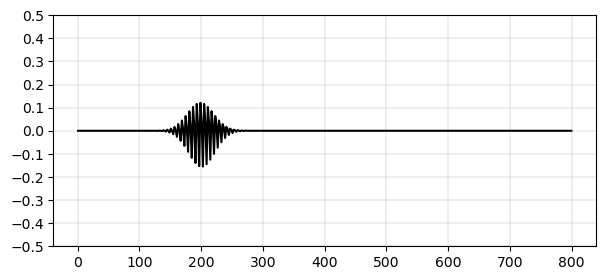

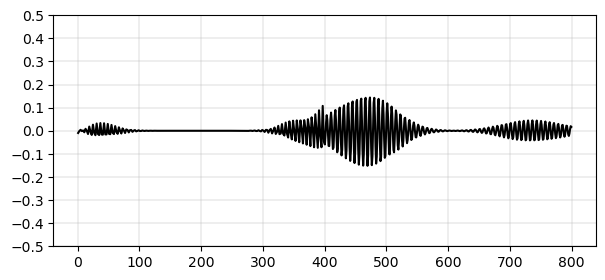

In [5]:
NX = 600             # Number of h points in the computational domain.
                     # The number of points will need to change depending on your resolution.
Domain_length = 800  # Length of the domain, in m.
wavelength = 6.0     # Wavelength in m.
decay_scale = 30.0   # The envelope decay scale, in m.

visc_decay_scale = 0.001  # An envelope scale for added viscosity, in m.
visc_magnitude = 0.0      # The peak amplitude of the viscosity, in m2 s-1.
endtime=150       # The length of the run, in s.
H0 = 1.0          # Background thickness, in m.
g = 9.8           # Gravitational acceleration, in m/s.
max_CFL = 0.25    # The maximum CFL number, which sets the time step.
Grid_transition = 0.0   # The grid-spacing transition scale, in gridpoints.

# Allocate the arrays here for efficiency.  There is one more u point than
# h points so that both boundaries are calculated.
#  u  h  u  h  u  h  u  h  u ...
#  1  1  2  2  3  3  4  4  5
# This script uses a "Southwest" indexing convention.  Note that MOM6 uses a
# "Northeast" indexing convention.

# The computational domain for h runs from 2 to NX+1, with halo points at 1 and NX+2.
# The computational domain for u runs from 2 to NX+2, with halo points at 1 and NX+3.
# The u points at 2 and NX+2 duplicate each other in a reentrant domain, but both need
# to be calculated with open boundary conditions.
u = np.zeros((NX+3,1))
h = np.zeros((NX+2,1))
x_u = np.zeros((NX+3,1))
x_h = np.zeros((NX+2,1))
Kh = np.zeros((NX+2,1))
visc = np.zeros((NX+3,1))

# This line would set a uniform grid spacing.
# dx = np.ones((NX,1))   # Distance between u points, in m.
# These lines set the grid spacing to vary abruptly.
# dx = np.concatenate((np.ones((int(2*NX/3),1)),2.*np.ones((int(NX/3),1))))   # Distance between u-points, in m.
dx = np.concatenate((2.*np.ones((int(NX/3),1)),np.ones((int(2*NX/3),1))))   # Distance between u-points, in m.


if Grid_transition > 0.0:
    for i in range(NX+1):
        dx[i] = 1.5 + 0.5*np.tanh((i - 2*NX/3)/Grid_transition)

# Set tentative locations of u points, but with indices shifted by 1 point relative to u.
x = np.concatenate(([0], np.cumsum(dx)))

# Rescale the domain so that it is always the right length.  With simple
# prescriptions of the grid spacing, it should be unnecessary, but with more
# complicated forms, it ensures the right domain length.
rescale = Domain_length / (x[NX] - x[0])
for i in range(NX+1):
    x[i] = rescale*x[i]

# Transfer the x points onto the velocity grid, which has a halo point on
# either end.
for i in np.arange(1,NX+2):
    x_u[i] = x[i-1]

# Extrapolate for the other x_u points that are outside of the
# computational domain.
x_u[0] = 2.0*x_u[1] - x_u[2]
x_u[NX+2] = 2.0*x_u[NX+1] - x_u[NX]

for i in range(NX+2):
    x_h[i] = 0.5*(x_u[i]+x_u[i+1])

# Set up the inverse grid spacings.
Idx_u = np.zeros(NX+2)
for i in np.arange(1,NX+2):
    Idx_u[i] = 1.0 / (x_h[i] - x_h[i-1])   # The inverse grid spacing at u in m-1.

Idx_h = np.zeros(NX+2)
for i in np.arange(1,NX+1):
    Idx_h[i] = 1.0 / (x_u[i+1] - x_u[i])   # The inverse grid spacing at h in m-1.

# This gives about dt = 0.08
dt = 0.25/(np.sqrt(g*H0)*max(Idx_u[1:NX+2]))  # Set DT so that CFL = 0.25

# Set up u with an analytic initial condition.
for i in np.arange(1,NX+2):
    u[i] = np.exp(-((x_u[i]-200)/decay_scale)**2)*np.sin(2*np.pi*x_u[i]/wavelength)


# Here h gives a rightward propagating solution (mostly).  Advancing this half
# a timestep improves the isolation of the rightward component.
for i in np.arange(1,NX+1):
    h[i] = 0.5*(u[i]+u[i+1])*np.sqrt(H0/g) - H0*0.5*dt*Idx_h[i]*(u[i+1] - u[i])

# Set the Laplacian viscosity.
for i in np.arange(1,NX+1):
    Kh[i] = visc_magnitude * np.exp(-((x_u[i]-400)/visc_decay_scale)**2)

# Periodicity - update the halo points.
u[NX+1] = u[1]   # This should be unneeded, because this point was already valid.
u[NX+2] = u[2]
u[0]  = u[NX]
h[NX+1] = h[1]
h[0]  = h[NX]
Idx_h[NX+1] = Idx_h[1]
Idx_h[0]  = Idx_h[NX]
Kh[NX+1] = Kh[1]
Kh[0]  = Kh[NX]

# Plot the initial condition.
fig, ax = plt.subplots(figsize = (7,3))
ax.plot(x_h[1:NX+1], h[1:NX+1], "k-")
plt.yticks(np.arange(-0.5,0.6,0.1))
ax.xaxis.grid(linewidth = 0.3)
ax.yaxis.grid(linewidth = 0.3)
plt.show()

# Now do the time stepping.
n=0
for t in np.arange(0,endtime+dt,dt):
    n = n + 1
    # Calculate the drag due to a Laplacian viscosity, with a simple forward
    # Euler discretization.  This is in a separate loop than the velocity
    # updates so that only one time level is needed.
    for i in np.arange(1,NX+2):
        visc[i] = (Kh[i]*(u[i+1] - u[i])*Idx_h[i] - Kh[i-1]*(u[i] - u[i-1])*Idx_h[i-1]) * Idx_u[i]

    # Forward-backward time stepping on a staggered grid.  Step u first.
    for i in np.arange(1,NX+2):
        u[i] = u[i] - g*dt*Idx_u[i] * ( h[i] - h[i-1] ) + dt*visc[i]

    # Forward-backward time stepping on a staggered grid.  Now step h.
    for i in np.arange(1,NX+1):
        h[i] = h[i] - H0*dt*Idx_h[i] * ( u[i+1] - u[i])

    # Periodicity - update the halo points.
    u[NX+1] = u[1]   # This should be unneeded; this point was already valid.
    u[NX+2] = u[2]
    u[0]  = u[NX]
    h[NX+1] = h[1]
    h[0]  = h[NX]

    # Plot the thickness every 10 timesteps and at the end.
    # if (np.mod(n, 10) == 0) or (abs(t-endtime) <= 0.5*dt):
    if (abs(t-endtime) <= 0.5*dt):
        fig, ax = plt.subplots(figsize = (7,3))
        ax.plot(x_h[1:NX+1], h[1:NX+1], "k-")
        plt.yticks(np.arange(-0.5,0.6,0.1))
        ax.xaxis.grid(linewidth = 0.3)
        ax.yaxis.grid(linewidth = 0.3)
        plt.show()
